In [1]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

input_mzml_files = glob.glob('results/interim/*.mzML')

raw_data=[]
for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    raw_data.append(exp)

ref_index = [i[0] for i in sorted(enumerate([exp.size() for exp in raw_data]), key=lambda x:x[1])][-1]
aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
#aligner_par.setValue("max_num_peaks_considered", -1)
aligner.setParameters(aligner_par)
aligner.setReference(raw_data[ref_index])

for exp in raw_data[:ref_index] + raw_data[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(exp, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(exp, trafo, True)

for exp in raw_data:    
    mzml_file = os.path.join("results", "", "FFMI", "", "interim", "", 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[19:-5] +".mzML")
    MzMLFile().store(mzml_file, exp)

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [6]:
input_mzml_files=glob.glob("results/FFMI/interim/*.mzML")
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('resources/MetaboliteIdentification.tsv')

    # FeatureMap to store results
    fm = FeatureMap()

    # edit some parameters
    params = ff.getParameters()
    params[b'extract:mz_window'] = 10.0 
    #params[b'model:type']= b'asymmetric'
    #params[b'extract:rt_window'] = 30.0
    #:peak_width'] = 30.0  #adjust for wide peaks
    ff.setParameters(params)

    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm)

    # save FeatureMap to file
    ff_file = os.path.join("results", "", "FFMI", "", "interim", "", 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

IndexError: list index out of range

In [4]:
from collections import defaultdict
from functools import reduce
from pathlib import Path
from time import perf_counter
import sys

from IPython.core.display import display
from pandas import CategoricalDtype
import numpy as np
from pyopenms import *
import pandas as pd
import os

common_meta_value_types = {
    b'label': 'U30',
    b'spectrum_index': 'i',
    b'score_fit': 'f',
    b'score_correlation': 'f',
    b'FWHM': 'f',
    b'spectrum_native_id': 'U30',
    b"num_of_masstraces" : "f"
}

class FeatureMapDF(FeatureMap):
    def __init__(self):
        super().__init__()
    
    # meta_values = None (default), 'all' or list of meta value names
    def get_df(self, meta_values = None):
        # get all possible meta value keys in a set
        if meta_values == 'all':
            meta_values = set()
            for f in self:
                mvs = []
                f.getKeys(mvs)
                for m in mvs:
                    meta_values.add(m)
        elif not meta_values: # if None, set to empty list
            meta_values = []
        
        def gen(fmap: FeatureMap, fun):
            for f in fmap:
                yield from fun(f, meta_values)

        def extract_meta_data(f: Feature, meta_values):
            pep = f.getPeptideIdentifications()  # type: list[PeptideIdentification]
            bb = f.getConvexHull().getBoundingBox2D()
                
            vals = [f.getMetaValue(m) if f.metaValueExists(m) else np.NA for m in meta_values]   # find some NA or None value for numpy
            
            if len(pep) != 0:
                hits = pep[0].getHits()

                if len(hits) != 0:
                    besthit = hits[0]  # type: PeptideHit
                    yield f.getUniqueId(), besthit.getSequence().toString(), f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("PeptideRef"), f.getOverallQuality(), f.getIntensity()
                else:
                    yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("PeptideRef"), f.getOverallQuality(), f.getIntensity()
            else:
                yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("PeptideRef"), f.getOverallQuality(), f.getIntensity()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('sequence', 'U200'), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('RTstart', 'f'), ('RTend', 'f'), ("PeptideRef", 'U200'),
                    ('quality', 'f'), ('intensity', 'f')]
        
        for meta_value in meta_values:
            if meta_value in common_meta_value_types:
                mddtypes.append((meta_value.decode(), common_meta_value_types[meta_value]))
            else:
                mddtypes.append((meta_value.decode(), 'U50'))
        mdarr = np.fromiter(iter=gen(self, extract_meta_data), dtype=mddtypes, count=cnt)
        df= pd.DataFrame(mdarr).set_index('id').sort_values("mz").drop(columns= "sequence")
        return df

In [5]:
input_feature_files = glob.glob('results/FFMI/interim/*.featureXML')

for filename in input_feature_files:
    fmap = FeatureMapDF()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "FFMI", "", 'features_' + os.path.basename(filename)[:-10] +"csv")
    DF.to_csv(feature_csv)
    print(os.path.basename(filename))
    display(DF)
    #reduce RT window (way lower window if process) + peak width
    #quality : ask oliver alka/ 
    #process all raw data with Alignement etc - do not overwrite them
    #plot them to see the quality of peaks

FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
13095101779727991333,1,47.928902,139.087280,42.776073,53.565708,pyracrimycinA_m138.080002_z1_rt50.82,-15.438810,1.602672e+05
9180533369865473242,1,74.912376,155.077271,67.876930,82.682144,pyracrimycinB_m154.070007_z1_rt69.540001,-2.963465,2.948858e+05
13284468346873979930,1,57.960072,197.117279,54.535980,62.600803,GermicidinA_m196.110001_z1_rt52.169998,-12.036817,1.086268e+04
8892905793398887788,1,71.773277,402.207275,64.888199,78.882469,bioxalomycina2_m401.200012_z1_rt48.18,-21.757866,7.986283e+03
15846123102240996167,1,304.820862,566.277283,297.148682,307.930420,Coelichelin_m565.27002_z1_rt268.049988,-19.151228,8.912053e+03
17717641705215485105,1,358.488739,585.357300,350.076233,362.876862,dehydroxynocardamine_m584.349976_z1_rt351.070007,-20.892153,2.199906e+05
7090484819228531917,1,338.995972,587.337280,332.102142,345.936005,desmethylenylnocardamine_m586.330017_z1_rt339....,-18.402967,7.099035e+03
15212530097827107171,2,406.492371,712.417297,400.955475,409.503357,epemicinB_m1422.819946_z2_rt405.769989,1.347934,6.051410e+06
13019967491178406022,2,385.242096,793.447266,376.101715,391.109467,epemicinA_m1584.880005_z2_rt386.850006,1.331158,5.800665e+07


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
18376073618431316356,1,48.451050,139.087280,44.020023,52.242325,pyracrimycinA_m138.080002_z1_rt50.82,-11.265389,3.357229e+03
14446861000569250463,1,75.606407,155.077271,68.429375,83.476685,pyracrimycinB_m154.070007_z1_rt69.540001,-3.144252,7.545758e+04
4625413588690305688,1,57.500988,197.117279,54.414326,60.602009,GermicidinA_m196.110001_z1_rt52.169998,-10.585321,2.599085e+02
7495697802391757780,1,70.435722,402.207275,65.792015,75.819672,bioxalomycina2_m401.200012_z1_rt48.18,-14.044182,4.331465e+02
524678389798323583,1,269.869354,566.277283,262.079071,271.607971,Coelichelin_m565.27002_z1_rt268.049988,-17.238411,2.926251e+02
16923905318474777225,1,327.819824,585.357300,320.257782,335.319641,dehydroxynocardamine_m584.349976_z1_rt351.070007,-20.190039,1.680328e+03
9461894609118754832,1,332.595367,587.337280,327.518707,337.240082,desmethylenylnocardamine_m586.330017_z1_rt339....,-12.307057,1.069738e+03
16775370452989931231,1,334.992950,601.357300,327.599548,342.229156,desferrioxamineE_m600.349976_z1_rt329.5,-19.809933,9.145388e+02
6181732187832543917,2,405.391022,712.417297,388.789673,416.644165,epemicinB_m1422.819946_z2_rt405.769989,1.323428,4.339979e+07


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
6440331215136395704,1,67.711319,139.087280,65.282684,71.399902,pyracrimycinA_m138.080002_z1_rt50.82,-8.830894,8103.155762
14524156392603769847,1,74.463135,155.077271,67.742065,81.173523,pyracrimycinB_m154.070007_z1_rt69.540001,-4.785629,12177.379883
14482383127872140375,1,55.880772,197.117279,49.207973,62.417233,GermicidinA_m196.110001_z1_rt52.169998,-20.730938,717.649353
4923731101032086742,1,259.775116,566.277283,254.618790,264.900635,Coelichelin_m565.27002_z1_rt268.049988,-17.379711,2109.605957
4337494988878417707,1,340.921021,587.337280,331.330719,348.588837,desmethylenylnocardamine_m586.330017_z1_rt339....,-0.437499,669014.125000
611217519947816428,1,341.988922,601.357300,337.883881,346.666077,desferrioxamineE_m600.349976_z1_rt329.5,-10.946842,6869.062500
3399843380282340912,2,415.167450,712.417297,407.151581,423.272583,epemicinB_m1422.819946_z2_rt405.769989,0.994932,45745.578125
871027635717947894,2,402.327972,793.447266,390.348907,416.641510,epemicinA_m1584.880005_z2_rt386.850006,1.341056,217096.406250
10699270691281474843,1,101.410225,1255.637329,93.902023,108.880562,actinomycinD_m1254.630005_z1_rt75.089996,-20.604218,3770.622070


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
11363010892608168473,1,78.479141,139.087280,72.073563,82.935677,pyracrimycinA_m138.080002_z1_rt50.82,-16.308273,1.267932e+05
9744314211200892890,1,65.965225,155.077271,61.069801,71.501755,pyracrimycinB_m154.070007_z1_rt69.540001,-16.314882,6.364745e+02
9168762975931416128,1,59.566589,197.117279,55.031921,64.165947,GermicidinA_m196.110001_z1_rt52.169998,-15.725694,3.508011e+02
2376132381544912751,1,49.411037,402.207275,42.524723,56.776207,bioxalomycina2_m401.200012_z1_rt48.18,-18.627800,7.084648e+03
11450627481000900908,1,273.524292,566.277283,264.702484,274.507812,Coelichelin_m565.27002_z1_rt268.049988,-16.890625,7.812017e+03
17838840209296923752,1,363.553589,585.357300,354.844574,371.529327,dehydroxynocardamine_m584.349976_z1_rt351.070007,-23.469629,7.966992e+03
10294995438516787319,1,336.024506,587.337280,327.235291,343.437683,desmethylenylnocardamine_m586.330017_z1_rt339....,-23.833130,1.124967e+04
1326571521067448387,1,344.624359,601.357300,338.975525,349.033112,desferrioxamineE_m600.349976_z1_rt329.5,-15.328129,6.780015e+03
2195292946131504559,2,405.469147,712.417297,395.353088,419.141113,epemicinB_m1422.819946_z2_rt405.769989,1.345345,5.217596e+08


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
10117008932691676864,1,45.534149,139.087280,42.777950,52.504871,pyracrimycinA_m138.080002_z1_rt50.82,-13.699884,1.262002e+06
12512577496964417728,1,76.234192,155.077271,63.787884,84.267609,pyracrimycinB_m154.070007_z1_rt69.540001,-4.291668,1.171630e+06
14894614407286351700,1,48.272869,197.117279,44.195526,51.961037,GermicidinA_m196.110001_z1_rt52.169998,-12.558494,4.748667e+04
2236878788001389547,1,68.284454,402.207275,60.409187,76.126083,bioxalomycina2_m401.200012_z1_rt48.18,-25.119864,2.914146e+04
3878959567104096750,1,302.899353,566.277283,292.129089,307.902557,Coelichelin_m565.27002_z1_rt268.049988,-26.454716,2.510053e+05
3442815092208618888,2,405.705475,712.417297,393.497406,417.221252,epemicinB_m1422.819946_z2_rt405.769989,1.352817,6.353339e+07
8061129336665221730,2,387.515869,793.447266,382.295563,390.412994,epemicinA_m1584.880005_z2_rt386.850006,1.258825,1.591709e+06
8316967775564786273,1,405.661804,1423.827271,396.006561,415.818115,epemicinB_m1422.819946_z1_rt405.769989,1.314058,3.556319e+06


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
5034614478048376753,1,45.992142,139.087280,44.336926,54.248135,pyracrimycinA_m138.080002_z1_rt50.82,-12.482636,109066.500000
16747178974005519915,1,76.998680,155.077271,69.083679,84.159828,pyracrimycinB_m154.070007_z1_rt69.540001,-23.264776,291302.687500
2856988014058783227,1,80.460640,197.117279,72.838692,92.041161,GermicidinA_m196.110001_z1_rt52.169998,-29.947750,65498.121094
6601505228091119653,1,48.324913,402.207275,44.336926,55.271305,bioxalomycina2_m401.200012_z1_rt48.18,-0.424303,76922.523438
9857122913895007935,1,252.165421,561.357300,244.614883,259.729279,DesferrioxamineB_m560.349976_z1_rt225.770004,-22.576679,55422.480469
3140137577000501366,1,267.900208,566.277283,265.074219,270.302765,Coelichelin_m565.27002_z1_rt268.049988,1.068435,42255.179688
8738057334881179687,1,371.739777,585.357300,360.293854,380.841980,dehydroxynocardamine_m584.349976_z1_rt351.070007,-31.151814,266888.906250
11654453659777867285,1,347.871521,587.337280,338.951996,358.935150,desmethylenylnocardamine_m586.330017_z1_rt339....,1.176393,322908.093750
12617366401730067305,1,329.313995,601.357300,325.860199,334.006561,desferrioxamineE_m600.349976_z1_rt329.5,-11.676385,199604.500000


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
10500294608056129783,1,47.455772,139.087280,42.502338,53.340656,pyracrimycinA_m138.080002_z1_rt50.82,0.416273,1.192823e+05
13877143777046374829,1,73.830185,155.077271,66.310532,81.753273,pyracrimycinB_m154.070007_z1_rt69.540001,-1.336870,2.846686e+05
2871646605008091679,1,49.171810,197.117279,43.395454,54.352924,GermicidinA_m196.110001_z1_rt52.169998,-17.881147,8.678396e+03
4739753953153284714,1,52.338970,402.207275,45.542580,59.446945,bioxalomycina2_m401.200012_z1_rt48.18,-21.294228,2.794794e+04
14400802283141013637,1,284.663483,566.277283,277.400879,291.877502,Coelichelin_m565.27002_z1_rt268.049988,-21.528587,1.787898e+04
6347631601860332025,1,358.416992,585.357300,349.846619,362.471405,dehydroxynocardamine_m584.349976_z1_rt351.070007,-3.371269,1.742070e+05
5514223928314907308,1,348.337463,587.337280,340.002441,357.896393,desmethylenylnocardamine_m586.330017_z1_rt339....,2.869970,9.963409e+04
17834640158114216514,1,340.322205,601.357300,333.077057,343.359283,desferrioxamineE_m600.349976_z1_rt329.5,-16.719269,1.062077e+04
12013915793699819058,2,405.907684,712.417297,400.558411,410.113617,epemicinB_m1422.819946_z2_rt405.769989,1.290635,1.957078e+07


FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
235736217805400059,1,52.065212,139.087280,49.740368,54.421345,pyracrimycinA_m138.080002_z1_rt50.82,-10.595037,8.335071e+03
839703405454649727,1,74.065178,155.077271,66.679398,81.428391,pyracrimycinB_m154.070007_z1_rt69.540001,3.019377,8.879614e+04
8620581670474629425,1,69.451012,197.117279,64.904121,75.349220,GermicidinA_m196.110001_z1_rt52.169998,-16.384130,1.848741e+04
14154181617623406124,1,53.889381,402.207275,47.566139,60.015911,bioxalomycina2_m401.200012_z1_rt48.18,-19.099504,8.209232e+03
11526905811731871994,1,372.136688,585.357300,363.121460,381.204712,dehydroxynocardamine_m584.349976_z1_rt351.070007,-2.985926,1.727546e+05
4019011749772268000,1,345.131195,587.337280,338.144348,351.782379,desmethylenylnocardamine_m586.330017_z1_rt339....,-0.411985,1.749563e+05
281215282513114028,1,340.126678,601.357300,332.662903,343.472198,desferrioxamineE_m600.349976_z1_rt329.5,-17.240948,1.393983e+04
14705358301491184227,2,406.051208,712.417297,398.712708,412.146698,epemicinB_m1422.819946_z2_rt405.769989,1.342504,7.275622e+07
4825552866222924182,2,382.997070,793.447266,374.377777,391.010437,epemicinA_m1584.880005_z2_rt386.850006,1.318721,6.673218e+07


FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
17677953619752588349,1,47.378910,139.087280,44.122730,50.816101,pyracrimycinA_m138.080002_z1_rt50.82,-14.529972,1.587660e+04
15724184294350352733,1,74.836975,155.077271,61.263981,83.218773,pyracrimycinB_m154.070007_z1_rt69.540001,-4.067994,4.520080e+05
10002884623737532000,1,61.404781,197.117279,54.028973,68.640312,GermicidinA_m196.110001_z1_rt52.169998,-3.143281,1.015380e+04
17384851956110005416,1,71.446251,402.207275,63.923981,77.141357,bioxalomycina2_m401.200012_z1_rt48.18,-21.120335,7.492260e+03
409010313478068713,1,276.383148,566.277283,269.326477,283.546814,Coelichelin_m565.27002_z1_rt268.049988,-20.420414,2.658488e+03
617780353410277678,1,337.556335,585.357300,329.999573,345.042084,dehydroxynocardamine_m584.349976_z1_rt351.070007,-20.186708,6.898257e+03
5206015058832994974,1,335.163391,587.337280,328.327881,342.108978,desmethylenylnocardamine_m586.330017_z1_rt339....,-18.974897,6.066009e+03
10165838519674212368,1,351.833221,601.357300,344.245300,359.401154,desferrioxamineE_m600.349976_z1_rt329.5,-20.851160,5.597828e+03
7603828859614495050,2,405.336090,712.417297,393.363678,416.870819,epemicinB_m1422.819946_z2_rt405.769989,1.348382,4.253774e+07


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
4329125685162746572,1,71.648727,139.087280,68.528053,74.691269,pyracrimycinA_m138.080002_z1_rt50.82,-9.178679,1.000529e+05
12478669782420175585,1,60.068703,155.077271,54.654274,65.579689,pyracrimycinB_m154.070007_z1_rt69.540001,-19.296463,1.435871e+04
10924599854482016940,1,67.216438,197.117279,55.660862,74.852989,GermicidinA_m196.110001_z1_rt52.169998,-29.078287,2.215955e+04
11878925822204255477,1,66.768288,402.207275,64.092529,69.304428,bioxalomycina2_m401.200012_z1_rt48.18,-8.171127,1.433237e+04
16724230952951189947,1,256.148102,561.357300,249.196594,263.301453,DesferrioxamineB_m560.349976_z1_rt225.770004,-20.261705,9.946922e+03
12569782106415182339,1,284.621429,566.277283,273.953033,298.053192,Coelichelin_m565.27002_z1_rt268.049988,-7.507241,3.844502e+05
3096878992160563997,1,368.694397,585.357300,361.533264,375.828766,dehydroxynocardamine_m584.349976_z1_rt351.070007,-19.662094,9.494669e+03
9099095387710945298,1,348.018494,587.337280,339.618713,354.300690,desmethylenylnocardamine_m586.330017_z1_rt339....,-23.485344,3.020540e+04
12644532785458963281,1,343.750000,601.357300,337.080170,348.584869,desferrioxamineE_m600.349976_z1_rt329.5,-15.065990,2.136237e+04


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
3433349084973967157,1,70.429466,139.087280,66.902550,74.000397,pyracrimycinA_m138.080002_z1_rt50.82,-10.743712,8.148317e+04
16567782794987486668,1,55.242512,155.077271,49.116203,61.405228,pyracrimycinB_m154.070007_z1_rt69.540001,-18.351675,5.401431e+03
15400290541006290173,1,70.321060,197.117279,63.246769,77.685204,GermicidinA_m196.110001_z1_rt52.169998,-22.678354,3.110517e+03
12381740163629047345,1,58.410797,402.207275,50.842045,71.625618,bioxalomycina2_m401.200012_z1_rt48.18,-31.727779,2.287477e+04
4450067933570275864,1,290.146423,566.277283,282.768890,295.637115,Coelichelin_m565.27002_z1_rt268.049988,-16.181623,7.794763e+04
11630102465691678554,1,364.738831,585.357300,354.656891,371.381012,dehydroxynocardamine_m584.349976_z1_rt351.070007,-26.630608,1.132265e+04
11603378912296807724,1,335.654999,587.337280,330.809814,341.393005,desmethylenylnocardamine_m586.330017_z1_rt339....,-12.505597,8.400711e+03
13314653289235003598,1,343.824188,601.357300,336.533600,348.863739,desferrioxamineE_m600.349976_z1_rt329.5,-0.279321,2.189019e+04
13528581451521619436,2,405.372559,712.417297,396.595551,418.994110,epemicinB_m1422.819946_z2_rt405.769989,1.348920,8.214998e+07


FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,PeptideRef,quality,intensity
id,,,,,,,,
9590860368200956284,1,68.544136,139.087280,63.962193,69.926842,pyracrimycinA_m138.080002_z1_rt50.82,-8.891990,26307.009766
9977483707483185929,1,68.192017,155.077271,65.001564,71.571541,pyracrimycinB_m154.070007_z1_rt69.540001,-11.870393,1582.724243
9295487390510440820,1,82.720345,197.117279,74.980827,92.091377,GermicidinA_m196.110001_z1_rt52.169998,-26.643791,4671.842773
4330067147738206771,1,51.939133,402.207275,49.112221,55.201633,bioxalomycina2_m401.200012_z1_rt48.18,-8.947855,10106.389648
12353623932941503836,1,254.922226,566.277283,246.580292,263.055573,Coelichelin_m565.27002_z1_rt268.049988,-27.671965,21835.380859
8481289671948996707,1,375.826660,585.357300,368.328369,383.286926,dehydroxynocardamine_m584.349976_z1_rt351.070007,-21.149033,10590.919922
17106969757550980030,1,330.037537,587.337280,322.774963,337.263336,desmethylenylnocardamine_m586.330017_z1_rt339....,-15.477373,38715.589844
11922179765230346055,1,340.280731,601.357300,332.708984,347.696045,desferrioxamineE_m600.349976_z1_rt329.5,-16.716536,27106.359375
14158125494037956736,2,407.173401,712.417297,399.099121,421.370605,epemicinB_m1422.819946_z2_rt405.769989,1.336918,76139.210938


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

filename = 'results/FFMI/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML'

def plotDetectedFeatures3D(path_to_featureXML):
    fm = FeatureMap()
    fh = FeatureXMLFile()
    fh.load(path_to_featureXML, fm)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for feature in fm:
        color = next(ax._get_lines.prop_cycler)['color']
        # chromatogram data is stored in the subordinates of the feature
        for i, sub in enumerate(feature.getSubordinates()):
            retention_times = [x[0] for x in sub.getConvexHulls()[0].getHullPoints()]
            intensities = [int(y[1]) for y in sub.getConvexHulls()[0].getHullPoints()]
            mz = sub.getMetaValue('MZ')
            ax.plot(retention_times, intensities, zs = mz, zdir = 'x', color = color)
            if i == 0:
                ax.text(mz,retention_times[0], max(intensities)*1.02, feature.getMetaValue('label'), color = color)

    ax.set_ylabel('time (s)')
    ax.set_xlabel('m/z')
    ax.set_zlabel('intensity (cps)')
    plt.show()


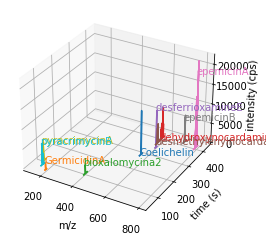

In [17]:
plotDetectedFeatures3D(filename)